In [ ]:
import itertools
import math
import torch
import torch.nn as nn
import torch.nn.functional as nnf
import einops.layers.torch as elt
import einops
from typing import List, Tuple, Optional, Type
from timm.layers import DropPath

import matplotlib.pyplot as plt

Image shape: torch.Size([1, 1, 16, 16])
Patches shape: torch.Size([1, 4, 4, 16])
Patches projected shape: torch.Size([1, 4, 4, 12])
Sequence shape: torch.Size([1, 16, 12])


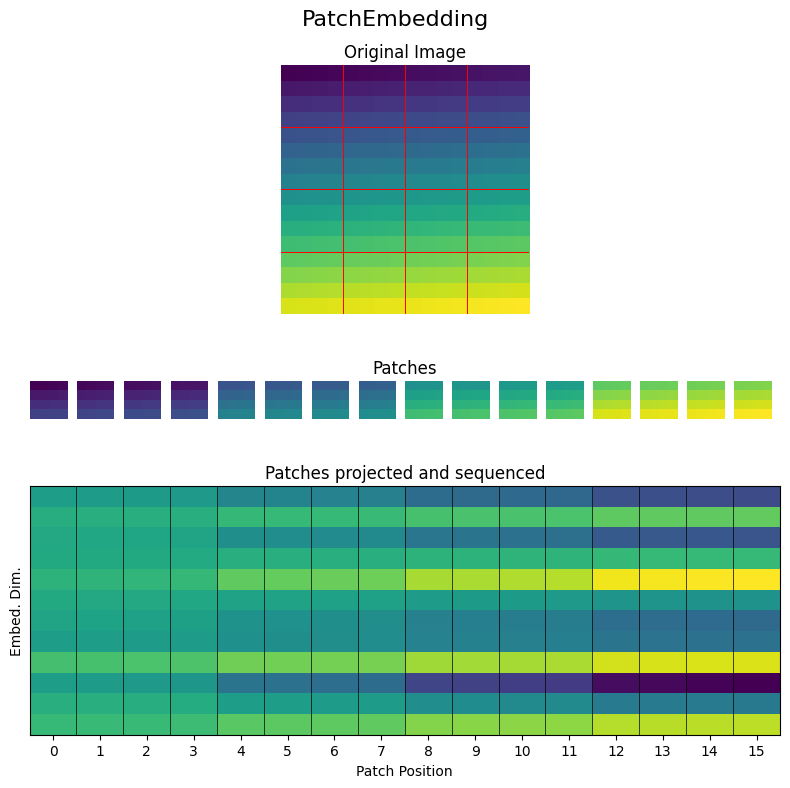

In [104]:
torch.manual_seed(0)

input_size = (16, 16)
patch_size = (4, 4)
hdm, wdm = input_size[0] // patch_size[0], input_size[1] // patch_size[1]
in_channels = 1
embed_dim = 12

image = torch.arange(0, input_size[0] * input_size[1] * in_channels, dtype=torch.float32).reshape(
    1, in_channels, input_size[0], input_size[1]
)

patches = einops.rearrange(image, "b c (hdm hm) (wdm wm) -> b hdm wdm (hm wm c)", hm=patch_size[0], wm=patch_size[1])
patches_projected = nn.Linear(in_channels * patch_size[0] * patch_size[1], embed_dim)(patches)
sequence = einops.rearrange(patches_projected, "b hdm wdm c -> b (hdm wdm) c", hdm=hdm, wdm=wdm)

print("Image shape:", image.shape)
print("Patches shape:", patches.shape)
print("Patches projected shape:", patches_projected.shape)
print("Sequence shape:", sequence.shape)

# Visualization code
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
fig.suptitle("PatchEmbedding", fontsize=16)

# Original image
axs[0].imshow(image[0, 0].detach().numpy(), cmap="viridis")
axs[0].set_title("Original Image")
axs[0].axis("off")
for i, j in itertools.product(range(hdm-1), range(wdm-1)):
    axs[0].axvline((j + 1) * patch_size[1] - 0.5, color="red", lw=0.5)
    axs[0].axhline((i + 1) * patch_size[0] - 0.5, color="red", lw=0.5)

# Patches
patch_img = einops.rearrange(
    patches[0].detach(), "hdm wdm (hm wm c) ->  c (hdm wdm) hm wm", hdm=hdm, wdm=wdm, hm=patch_size[0], wm=patch_size[1]
)
patch_img = nnf.pad(patch_img, (0, 1, 0, 0), value=torch.nan)
patch_img = einops.rearrange(patch_img, "c win hm wm -> hm (win wm) c", hm=patch_size[0], wm=patch_size[1] + 1)
axs[1].imshow(patch_img.numpy(), cmap="viridis")
axs[1].set_title("Patches")
axs[1].axis("off")

# Patches projected
proj_img = einops.rearrange(patches_projected[0].detach(), "hdm wdm c -> (c) (hdm wdm)")
axs[2].imshow(proj_img.numpy(), cmap="viridis", aspect="auto")
axs[2].set_title("Patches projected and sequenced")
axs[2].set_ylabel("Embed. Dim.")
axs[2].set_xlabel("Patch Position")
axs[2].set_yticks([])
axs[2].set_xticks(list(range(proj_img.shape[1])))
for i in range(proj_img.shape[1]):
    axs[2].axvline(i - 0.5, color="black", lw=0.5)

plt.tight_layout()
plt.show()